In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
from plots import *
from split_data import *
from recommender import *
from cross_validation import *
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


## Split data into training and test set

In [3]:
def split_data(ratings, p_test=0.1, seed=45):
    
    # set seed
    np.random.seed(seed)
    
    # generate random indices
    row = ratings.shape[0]
    col = ratings.shape[1]
    num = row*col
    
    indices = np.random.permutation(num)
    index_split = int(np.floor(p_test * num))
    
    index_tr_n = indices[: index_split]
    index_te_n = indices[index_split:]
    
    
    
    rat_arr = ratings.toarray()
    
    # reshaping
    valid_array_te = np.copy(rat_arr).reshape((num,1))
    valid_array_tr = np.copy(rat_arr).reshape((num,1))  
    
    # create split
    train = valid_array_tr
    train[index_tr_n] = 0
    train = train.reshape((row,col))
    
    test = valid_array_te
    test[index_te_n] = 0
    test = test.reshape((row,col))
    
    # ***************************************************
    
    #print (valid_ratings, train, test)
    return rat_arr, train, test
print("function 'compiled'")

function 'compiled'


In [4]:
rats, train, test = split_data(ratings, p_test=0.1, seed=46)
print("done")#2:10 much quicker than that :)


done


In [5]:
def user_mean(data):
    nnz_u = np.copy(data)
    nnz_u[np.where( data > 0 )] = 1
    return train.sum(axis=0) / nnz_u.sum(axis=0)

def item_mean(data):
    
    nnz_i = np.copy(data)
    nnz_i[np.where( data >1 )] = 1
    return train.sum(axis=1) / nnz_i.sum(axis=1)
    
print("functions 'compiled'")

functions 'compiled'


In [6]:
def init_MF_ALS_biased(train, num_features, factor_features=0.1, factor_biases=1):
    num_items, num_users = train.shape
    user_features = factor_features*np.ones((num_users,num_features))
    item_features = factor_features*np.ones((num_items,num_features))
    user_biases = factor_biases*np.ones(num_users)
    item_biases = factor_biases*np.ones(num_items)
    return user_features, item_features, user_biases, item_biases
print("function 'compiled'")

function 'compiled'


In [7]:
def init_MF_ALS(train, num_features, factor_features=0.1):
    num_items, num_users = train.shape
    user_features = factor_features*np.ones((num_users,num_features))
    item_features = factor_features*np.ones((num_items,num_features))
    return user_features, item_features
print("function 'compiled'")   

function 'compiled'


In [8]:
def data_user_biased(data, user_biases):
    data_user_biased = data - user_biases
    return data_user_biased
def data_item_biased(data, item_biases):
    data_item_biased = (data.T - item_biases).T
    return  data_item_biased
print("functions 'compiled'")

functions 'compiled'


In [9]:
def compute_error_prediction(data, prediction, nz):
    real_label = np.array([data[d,n] for (d,n) in nz])
    prediction_label = np.array([prediction[d,n] for (d,n) in nz])
    rmse = np.sqrt((1/len(nz))*calculate_mse(real_label,prediction_label))
    return rmse
print("function 'compiled'")

function 'compiled'


In [10]:
def prediction_biased(item_features, item_biases, user_features, user_biases):    
    prediction_data =    user_features.dot(item_features.T).T
    prediction = ((prediction_data + user_biases).T + item_biases).T       
    return prediction
print("function 'compiled'")

function 'compiled'


In [11]:
def update_item_biased_feature(train, user_features, user_biases, lambda_item, nnz_users_per_item, nz_item_userindices):
    
    num_users, num_features = user_features.shape
    num_items = train.shape[0]
    ones_biases = np.array([np.ones(num_users)])
    item_biases = np.zeros(num_items)
    item_features = np.zeros((num_items,num_features))         
        
    for item in np.arange(num_items): 
        nnz_users = nnz_users_per_item[item]
        nz_userindices = nz_item_userindices[item]
        nz_userfeatures = user_features[nz_userindices,:]
        nz_onesbiases = ones_biases[:,nz_userindices]
        nz_userbiases = user_biases[nz_userindices]
    
    
        Xt = np.concatenate((nz_onesbiases, nz_userfeatures.T), axis=0)
        A = Xt.dot(Xt.T) + lambda_item*nnz_users*np.eye(num_features+1)  
        train_item = (train[item,nz_userindices])
        b = Xt.dot(data_user_biased(train_item, nz_userbiases).T) 

        Yt = np.linalg.solve(A,b)
        
        item_features[item,:] = Yt[1:num_features+1]
        item_biases[item] = Yt[0]

    return item_features, item_biases

def update_user_biased_feature(train, item_features, item_biases, lambda_user, nnz_items_per_user, nz_user_itemindices):
    
    num_users = train.shape[1]
    num_items, num_features = item_features.shape
    ones_biases = np.array([np.ones(num_items)])
    user_biases = np.zeros(num_users)
    user_features = np.zeros((num_users,num_features))
    
    for user in np.arange(num_users):        
        nnz_items = nnz_items_per_user[user]
        nz_itemindices = nz_user_itemindices[user]
        nz_itemfeatures = item_features[nz_itemindices,:]
        nz_onesbiases = ones_biases[:,nz_itemindices]
        nz_itembiases = item_biases[nz_itemindices]
        
    
        Yt = np.concatenate((nz_onesbiases, nz_itemfeatures.T), axis=0)
        A = Yt.dot(Yt.T) + lambda_user*nnz_items*np.eye(num_features+1)  
        train_user = train[nz_itemindices,user]
        b = Yt.dot(data_item_biased(train_user, nz_itembiases)) 
        Xt = np.linalg.solve(A,b)
        
        user_features[user,:] = Xt[1:num_features+1]
        user_biases[user] = Xt[0]

    return user_features, user_biases

print("functions 'compiled'")

functions 'compiled'


In [13]:
def ALS_biased(train, test, num_features = 10, lambda_user = 0.1, lambda_item = 0.1, seed=552):
    
    stop_criterion = 1e-7

    error_list = [0, 0]
    max_it = 10 
    
    error_old = 10
    error_new = 5
    
    # set seed
    np.random.seed(seed)

    # init ALS
    user_features, item_features, user_biases, item_biases = init_MF_ALS_biased(train, num_features)
    
    # ***************************************************
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))    
    
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)
    _,nz_user_itemindices = map(list,zip(*nz_col_rowindices))
    nnz_items_per_user = [len(i) for i in nz_user_itemindices]
    _,nz_item_userindices = map(list,zip(*nz_row_colindices))
    nnz_users_per_item = [len(i) for i in nz_item_userindices]

    print("learn the matrix factorization using ALS...")

    for it in np.arange(max_it):
        
        
        item_features, item_biases = update_item_biased_feature(train, user_features, user_biases, lambda_item, nnz_users_per_item, nz_item_userindices)
        user_features, user_biases = update_user_biased_feature(train, item_features, item_biases, lambda_user, nnz_items_per_user, nz_user_itemindices)
        
        prediction = prediction_biased(item_features, item_biases, user_features, user_biases)        
        rmse = compute_error_prediction(train, prediction, nz_train)        
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        error_new = compute_error_prediction(test, prediction, nz_test)
        
        error_list.append(rmse)
        if abs(error_list[-1]-error_list[-2])<stop_criterion:
            break
        if error_new>error_old:
            print("Best iter: {}, with RMSE on test data: {}. ".format(it-1,error_old))
            break
        error_old = error_new

    prediction = prediction_biased(item_features, item_biases, user_features, user_biases)
    rmse = compute_error_prediction(test, prediction, nz_test)
    #print("RMSE on test data: {}.".format(rmse))
    #print("done")
    return error_old
    
    # ***************************************************

ALS_biased(train, test)

learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9992039618771512.
iter: 1, RMSE on training set: 0.9876753791248908.
iter: 2, RMSE on training set: 0.9864005907408453.
iter: 3, RMSE on training set: 0.9867920781431252.
Best iter: 2, with RMSE on test data: 1.0004500614216185. 


1.0004500614216185

In [12]:
def prediction_non_biased(item_features, user_features):    
    prediction = user_features.dot(item_features.T).T    
    return prediction
print("function 'compiled'")

function 'compiled'


In [13]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    # ***************************************************
    num_items,num_users = train.shape
    num_features = item_features.shape[1]
    user_feature = np.zeros((num_users,num_features))
    for user in np.arange(num_users):
        nnz_items = nnz_items_per_user[user]
        nz_itemindices = nz_user_itemindices[user]
        nz_itemfeatures = item_features[nz_itemindices,:]
        A = ((nz_itemfeatures.T).dot(nz_itemfeatures)+lambda_user*nnz_items*np.eye(num_features))
        train_user = train[nz_itemindices,user]
        b = ((nz_itemfeatures.T).dot(train_user))
        user_feature[user,:] = np.linalg.solve(A,b)
    # ***************************************************
    return user_feature

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    # ***************************************************
    num_items,num_users = train.shape
    num_features = user_features.shape[1]
    item_feature = np.zeros((num_items,num_features))
    for item in np.arange(num_items):
        nnz_users = nnz_users_per_item[item]
        nz_userindices = nz_item_userindices[item]
        nz_userfeatures = user_features[nz_userindices,:]
        A = ((nz_userfeatures.T).dot(nz_userfeatures)+lambda_item*nnz_users*np.eye(num_features))
        train_item = (train[item,nz_userindices])
        b = ((nz_userfeatures.T).dot(train_item))
        item_feature[item,:] = np.linalg.solve(A,b)
    # ***************************************************
    return item_feature
print("functions 'compiled'")

functions 'compiled'


In [16]:
def ALS(train, test, num_features = 10, lambda_user = 0.1, lambda_item = 0.1, seed=552):
    
    stop_criterion = 1e-7

    error_list = [0, 0]
    max_it = 10 
    
    error_old = 10
    error_new = 5
    
    # set seed
    np.random.seed(seed)

    # init ALS
    user_features, item_features = init_MF_ALS(train, num_features)
    
    # ***************************************************
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))    
    
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    
    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)
    _,nz_user_itemindices = map(list,zip(*nz_col_rowindices))
    nnz_items_per_user = [len(i) for i in nz_user_itemindices]
    _,nz_item_userindices = map(list,zip(*nz_row_colindices))
    nnz_users_per_item = [len(i) for i in nz_item_userindices]

    print("learn the matrix factorization using ALS...")

    for it in np.arange(max_it):
        
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)

        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        
        prediction = prediction_non_biased(item_features, user_features)
        
        rmse = compute_error_prediction(train, prediction, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        error_new = compute_error_prediction(test, prediction, nz_test)
        error_list.append(rmse)
        if abs(error_list[-1]-error_list[-2])<stop_criterion:
            break
        if error_new>error_old:
            print("Best iter: {}, with RMSE on test data: {}. ".format(it-1,error_old))
            break
        error_old = error_new
        
    prediction = prediction_non_biased(item_features, user_features)
    rmse = compute_error_prediction(test, prediction, nz_test)
    #print("RMSE on test data: {}.".format(rmse))
    #print("done")
    return error_old
    
    # ***************************************************

ALS(train, test)

learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9959192861108764.
iter: 1, RMSE on training set: 0.9912939750943721.
iter: 2, RMSE on training set: 0.9908659304261874.
iter: 3, RMSE on training set: 0.990810472982908.
iter: 4, RMSE on training set: 0.9908690709872654.
Best iter: 3, with RMSE on test data: 1.002509533585753. 


1.002509533585753

In [14]:
#need k be multiple of row*col
def k_indices_set_generator(ratings, k=5, seed=48):
    
    # set seed
    np.random.seed(seed)
    
    # generate random indices
    row = ratings.shape[0]
    col = ratings.shape[1]
    num = row*col
    
    indices = np.random.permutation(num)
    
    index_split = int(num/k)
    k_indices_set = np.zeros((k,index_split),dtype=np.int)   
    
    for i in range(k):    
        id_start = index_split*i
        id_end = index_split*(i+1)
        k_indices_set[i] = indices[id_start:id_end]
    
    return k_indices_set
print("function 'compiled'")

function 'compiled'


In [15]:
def split_data_k(ratings, k_indices_set, k):
    
    K, index_split = k_indices_set.shape
    index_tr = k_indices_set[np.where(np.arange(K) != (k-1))].reshape(((K-1)*index_split,1))[:,0]
    index_te = k_indices_set[k-1]
    
    row = ratings.shape[0]
    col = ratings.shape[1]
    num = row*col
    
    rat_arr = ratings.toarray()
    
    # reshaping
    valid_array_te = np.copy(rat_arr).reshape((num,1))
    valid_array_tr = np.copy(rat_arr).reshape((num,1))  
    
    # create split
    train = valid_array_tr
    train[index_te] = 0
    train = train.reshape((row,col))
    
    test = valid_array_te
    test[index_tr] = 0
    test = test.reshape((row,col))
    
    # ***************************************************
    
    #print (valid_ratings, train, test)
    return train, test
print("function 'compiled'")

function 'compiled'


In [16]:
def cross_validation_minimalist(ratings, K, num_features=5, lambda_user=0.01, lambda_item=0.01):
    
    k_indices_set = k_indices_set_generator(ratings,10)    

    train_rmse_arr=[]
    validation_rmse_arr=[]
        
    for k in range(K):
        print('Running {}th fold in {} folds'.format(k+1, K))
        train_cross,test_cross = split_data_k(ratings, k_indices_set, k+1)
        #train_rmse, validation_rmse = ALS_Biased(training, validation, num_features, lambda_user, lambda_item)
        validation_rmse = ALS_biased(train_cross, test_cross, num_features, lambda_user, lambda_item)    
        #train_rmse_arr.append(train_rmse)
        validation_rmse_arr.append(validation_rmse)
        
    return validation_rmse_arr
print("function 'compiled'")

function 'compiled'


In [92]:
## !!! Takes long time to run
def best_lambda_user(lambda_user_arr = [0.001, 0.01, 0.1, 1]):
    
    K = 4        ## K-fold cross validation
    num_features = 8   # K in the lecture notes
    
    lambda_item = 0.05

    train_rmse_mean = np.zeros(len(lambda_user_arr))
    train_rmse_std = np.zeros(len(lambda_user_arr))
    validation_rmse_mean = np.zeros(len(lambda_user_arr))
    validation_rmse_std = np.zeros(len(lambda_user_arr))

    for i, lambda_user in enumerate(lambda_user_arr):
        train_rmse_arr = []
        validation_rmse_arr = []

        print('Running lambda_user={n}'.format(n=lambda_user))
        validation_rmse_arr = cross_validation_minimalist(ratings, K, num_features, lambda_user, lambda_item)

        #train_rmse_mean[i] = np.mean(train_rmse_arr)
        #train_rmse_std[i] = np.std(train_rmse_arr)
        validation_rmse_mean[i] = np.mean(validation_rmse_arr)
        validation_rmse_std[i] = np.std(validation_rmse_std)

    ## Plotting results
    #plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
    #                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
    plt.fill_between(lambda_user_arr, validation_rmse_mean - validation_rmse_std,
                         validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
    #plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
    plt.plot(lambda_user_arr, validation_rmse_mean, 'o-', color="g")
    plt.legend(('Train', 'Validation'))
    plt.xlabel('Lambda user'); plt.ylabel('RMSE');
    plt.show()
    return list(zip(lambda_user_arr, validation_rmse_mean)) 
print("function 'compiled'")

function 'compiled'


Running lambda_user=0.001
Running 1th fold in 4 folds
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9929769056420532.
iter: 1, RMSE on training set: 0.9800142814275047.
iter: 2, RMSE on training set: 0.9778031585836828.
iter: 3, RMSE on training set: 0.9760414437807262.
iter: 4, RMSE on training set: 0.9747376355936678.
iter: 5, RMSE on training set: 0.9727227409024222.
iter: 6, RMSE on training set: 0.914966508465358.
Best iter: 5, with RMSE on test data: 0.9948228573310891. 
Running 2th fold in 4 folds
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9928747129890845.
iter: 1, RMSE on training set: 0.9797753201128424.
iter: 2, RMSE on training set: 0.977563332740611.
iter: 3, RMSE on training set: 0.9758970875471963.
iter: 4, RMSE on training set: 0.9746938801399431.
iter: 5, RMSE on training set: 0.973649757729912.
iter: 6, RMSE on training set: 0.9147112132295677.
Best iter: 5, with RMSE on test data: 0.9954410604502942. 
R

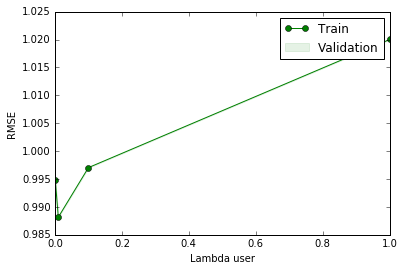

In [98]:
best_lambda_u = best_lambda_user()

In [99]:
best_lambda_u

[(0.001, 0.99476578675589289),
 (0.01, 0.98815360195381285),
 (0.1, 0.99704064721117247),
 (1, 1.0200033806812665)]

In [94]:
## !!! Takes long time to run
def best_lambda_item(lambda_item_arr = [0.001, 0.01, 0.1, 1]):
    
    K = 4        ## K-fold cross validation
    num_features = 8   # K in the lecture notes
    
    lambda_user = 0.05

    train_rmse_mean = np.zeros(len(lambda_item_arr))
    train_rmse_std = np.zeros(len(lambda_item_arr))
    validation_rmse_mean = np.zeros(len(lambda_item_arr))
    validation_rmse_std = np.zeros(len(lambda_item_arr))

    for i, lambda_item in enumerate(lambda_item_arr):
        train_rmse_arr = []
        validation_rmse_arr = []

        print('Running lambda_item={n}'.format(n=lambda_item))
        validation_rmse_arr = cross_validation_minimalist(ratings, K, num_features, lambda_user, lambda_item)

        #train_rmse_mean[i] = np.mean(train_rmse_arr)
        #train_rmse_std[i] = np.std(train_rmse_arr)
        validation_rmse_mean[i] = np.mean(validation_rmse_arr)
        validation_rmse_std[i] = np.std(validation_rmse_std)

    ## Plotting results
    #plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
    #                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
    plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                         validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
    #plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
    plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
    plt.legend(('Train', 'Validation'))
    plt.xlabel('Lambda item'); plt.ylabel('RMSE');
    plt.show()
    return list(zip(lambda_item_arr, validation_rmse_mean)) 
print("function 'compiled'")

function 'compiled'


Running lambda_item=0.001
Running 1th fold in 4 folds
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9960873357185817.
iter: 1, RMSE on training set: 0.976612366897327.
iter: 2, RMSE on training set: 0.9755615526330195.
iter: 3, RMSE on training set: 0.9752286440620399.
iter: 4, RMSE on training set: 0.9750605669518985.
iter: 5, RMSE on training set: 0.9748829115354556.
iter: 6, RMSE on training set: 0.9200355362361152.
Best iter: 5, with RMSE on test data: 0.9973768914304485. 
Running 2th fold in 4 folds
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9959573686539831.
iter: 1, RMSE on training set: 0.9765698268606118.
iter: 2, RMSE on training set: 0.975497949543537.
iter: 3, RMSE on training set: 0.9751557762863479.
iter: 4, RMSE on training set: 0.9749829979994818.
iter: 5, RMSE on training set: 0.9746601479117892.
iter: 6, RMSE on training set: 0.9201063005385897.
Best iter: 5, with RMSE on test data: 0.9977742418776714. 


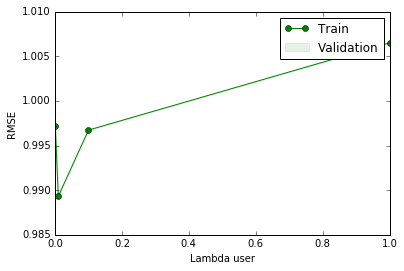

In [96]:
best_lambda_i = best_lambda_item()

In [97]:
best_lambda_i

[(0.001, 0.99720185273651563),
 (0.01, 0.98931868962408664),
 (0.1, 0.99672803470611282),
 (1, 1.0065030540022599)]

In [103]:
## !!! Takes long time to run
def best_num_features(num_features_arr = [1, 4, 7, 10,13]):
    
    K = 4        ## K-fold cross validation
    
    lambda_item = 0.01
    lambda_item = 0.01

    #train_rmse_mean = np.zeros(len(lambda_user_arr))
    #train_rmse_std = np.zeros(len(lambda_user_arr))
    validation_rmse_mean = np.zeros(len(num_features_arr))
    validation_rmse_std = np.zeros(len(num_features_arr))

    for i, num_features in enumerate(num_features_arr):
        #train_rmse_arr = []
        validation_rmse_arr = []

        print('Running num_features={n}'.format(n=num_features))
        validation_rmse_arr = cross_validation_minimalist(ratings, K, num_features, lambda_user, lambda_item)

        #train_rmse_mean[i] = np.mean(train_rmse_arr)
        #train_rmse_std[i] = np.std(train_rmse_arr)
        validation_rmse_mean[i] = np.mean(validation_rmse_arr)
        validation_rmse_std[i] = np.std(validation_rmse_std)

    ## Plotting results
    #plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
    #                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
    plt.fill_between(num_features_arr, validation_rmse_mean - validation_rmse_std,
                         validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
    #plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
    plt.plot(num_features_arr, validation_rmse_mean, 'o-', color="g")
    plt.legend(('Train', 'Validation'))
    plt.xlabel('num_features'); plt.ylabel('RMSE');
    plt.show()
    return list(zip(num_features_arr, validation_rmse_mean)) 
print("function 'compiled'")

function 'compiled'


Running num_features=1
Running 1th fold in 4 folds
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 1.1361536689012746.
iter: 1, RMSE on training set: 1.0077795772000133.
iter: 2, RMSE on training set: 0.9901997506708349.
iter: 3, RMSE on training set: 0.9868550758734739.
iter: 4, RMSE on training set: 0.9853504841674874.
iter: 5, RMSE on training set: 0.9844845258313454.
iter: 6, RMSE on training set: 0.9839283053799376.
iter: 7, RMSE on training set: 0.9835499297048161.
iter: 8, RMSE on training set: 0.9832846598463315.
iter: 9, RMSE on training set: 0.9830956763324021.
Running 2th fold in 4 folds
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 1.1360132050597316.
iter: 1, RMSE on training set: 1.0077411118316377.
iter: 2, RMSE on training set: 0.990139534944165.
iter: 3, RMSE on training set: 0.9867932167007988.
iter: 4, RMSE on training set: 0.9852887654598792.
iter: 5, RMSE on training set: 0.9844230351658583.
iter: 6, RMSE on t

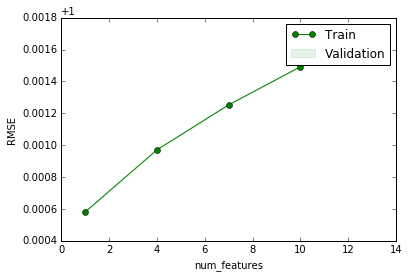

In [104]:
best_num_f = best_num_features()

In [105]:
best_num_f

[(1, 1.0005820872169715),
 (4, 1.0009716084838933),
 (7, 1.0012537121532528),
 (10, 1.0014926039174503),
 (13, 1.0017085792314464)]

In [18]:
def ALS_biased_prediction(train, test, num_features = 1, lambda_user = 0.01, lambda_item = 0.01, seed=552):
    
    stop_criterion = 1e-7

    error_list = [0, 0]
    max_it = 50
    
    error_old = 10
    error_new = 5
    
    # set seed
    np.random.seed(seed)

    # init ALS
    user_features, item_features, user_biases, item_biases = init_MF_ALS_biased(train, num_features)
    
    # ***************************************************
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))    
    
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)
    _,nz_user_itemindices = map(list,zip(*nz_col_rowindices))
    nnz_items_per_user = [len(i) for i in nz_user_itemindices]
    _,nz_item_userindices = map(list,zip(*nz_row_colindices))
    nnz_users_per_item = [len(i) for i in nz_item_userindices]

    print("learn the matrix factorization using ALS...")

    for it in np.arange(max_it):
        
        
        item_features, item_biases = update_item_biased_feature(train, user_features, user_biases, lambda_item, nnz_users_per_item, nz_item_userindices)
        user_features, user_biases = update_user_biased_feature(train, item_features, item_biases, lambda_user, nnz_items_per_user, nz_user_itemindices)
        
        prediction = prediction_biased(item_features, item_biases, user_features, user_biases)        
        rmse = compute_error_prediction(train, prediction, nz_train)        
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        error_new = compute_error_prediction(test, prediction, nz_test)
        
        error_list.append(rmse)
        if abs(error_list[-1]-error_list[-2])<stop_criterion:
            break
        if error_new>error_old:
            print("Best iter: {}, with RMSE on test data: {}. ".format(it-1,error_old))
            break
        error_old = error_new

    prediction = prediction_biased(item_features, item_biases, user_features, user_biases)
    rmse = compute_error_prediction(test, prediction, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    #print("done")
    return prediction
    
    # ***************************************************

print("function'compiled'")

function'compiled'


In [19]:
prediction = ALS_biased_prediction( train, test, 2) 

learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9943491028330717.
iter: 1, RMSE on training set: 0.9777961864210896.
iter: 2, RMSE on training set: 0.9747267256694103.
iter: 3, RMSE on training set: 0.9734723885790351.
iter: 4, RMSE on training set: 0.972975284893822.
iter: 5, RMSE on training set: 0.9727492139381406.
iter: 6, RMSE on training set: 0.9725910626493434.
iter: 7, RMSE on training set: 0.9595437575809322.
iter: 8, RMSE on training set: 0.957986669902135.
iter: 9, RMSE on training set: 0.9577428772370213.
iter: 10, RMSE on training set: 0.9576585901375495.
iter: 11, RMSE on training set: 0.957629999725439.
iter: 12, RMSE on training set: 0.9576226858930941.
iter: 13, RMSE on training set: 0.9576237537261081.
iter: 14, RMSE on training set: 0.9576280506531828.
iter: 15, RMSE on training set: 0.9576334402750372.
iter: 16, RMSE on training set: 0.9576390285926912.
iter: 17, RMSE on training set: 0.9576444546699232.
iter: 18, RMSE on training set: 0

In [21]:
pred = np.copy(prediction)
print("copy done")

copy done


In [22]:
#least square
def least_squares(y, tx):
    """
    Least squares using normal equations.
    """
    w = np.linalg.solve(tx.T.dot(tx), tx.T.dot(y))
    return w

def error_mse(y, tx, w):
    rmse = np.sqrt((1/len(y))*calculate_mse(y,tx.dot(w)))
    return rmse
def ridge_regression(y, tx,lambda_ = 0.1):
    """
    Least squares using normal equations (with L2 regularization)
    """
    
    reg = 2 * y.size * lambda_ * np.identity(tx.shape[1]) # L2 regularization term
    w = np.linalg.solve(tx.T.dot(tx) + reg, tx.T.dot(y))
    return w
print("functions'compiled'")

functions'compiled'


In [25]:
def feature_adding(train, test, pred):
    """
    built y = real_labels  tx = (pred, #user ratings, #movie ratings, mean rate per user, mean rate per movie)
    May be also add std deviation
    
    """
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    
    
    nnz_u = np.copy(train)
    nnz_u[np.where(train > 0)] = 1
    
    nnz_i = np.copy(train)
    nnz_i[np.where(train > 1)] = 1
    
    num_u = nnz_u.sum(axis=0)
    num_i = nnz_i.sum(axis=1)  
    mean_u = train.sum(axis=0)/num_u
    mean_i = train.sum(axis=1)/num_i
    
    
    std_u = np.std(train, axis=0)
    std_i = np.std(train, axis=1)
    
    y = np.array([train[d,n] for (d,n) in nz_train])
    y_test = np.array([test[d,n] for (d,n) in nz_test])
    
    
    tX = np.array([[pred[d,n],num_u[n],num_i[d],mean_u[n],mean_i[d],std_u[n],std_i[d]] for (d,n) in nz_train])
    tX_test = np.array([[pred[d,n],num_u[n],num_i[d],mean_u[n],mean_i[d],std_u[n],std_i[d]] for (d,n) in nz_test])
   
    return y, y_test, tX, tX_test
print("function'compiled'")

function'compiled'


In [26]:
y, y_test, tX, tX_test = feature_adding(train, test, pred)

In [32]:
w = ridge_regression(y, tX, 0.01)
print(error_mse(y, tX, w))
print(error_mse(y_test, tX_test, w))

0.959089393068
0.988555750743


In [33]:
import itertools
def feature_adding_all(train, test, pred):
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    
    
    nnz_u = np.copy(train)
    nnz_u[np.where(train > 0)] = 1
    
    nnz_i = np.copy(train)
    nnz_i[np.where(train > 1)] = 1
    
    num_u = nnz_u.sum(axis=0)
    num_i = nnz_i.sum(axis=1)  
    mean_u = train.sum(axis=0)/num_u
    mean_i = train.sum(axis=1)/num_i
    
    
    std_u = np.std(train, axis=0)
    std_i = np.std(train, axis=1)
    
    ind =  itertools.product(np.arange(train.shape[0]), np.arange(train.shape[1]))
    
    tX = np.array([[pred[d,n],num_u[n],num_i[d],mean_u[n],mean_i[d],std_u[n],std_i[d]] for (d,n) in ind])
   
    return tX
print("function'compiled'")

function'compiled'


In [36]:
tX_all = feature_adding_all(train, test, pred)
print("done")


done


In [37]:
def pred_all(tX_all, w):
    return tX_all.dot(w)

w_nth = np.array([1,0,0,0,0,0,0])
pred_all = pred_all(tX_all, w)
print("done")

done


In [38]:
pred_ready = pred_all.reshape((pred.shape[0], pred.shape[1]))
print(pred_ready.shape)

(10000, 1000)


In [39]:
def submit_predictions(prediction, outputFilename, sampleSubmissionFilename):
    import csv
    
    ## Read the indices 
    with open('../data/sampleSubmission.csv','r') as csvinput:
        reader = csvinput.read().splitlines()
        i=-1
        ind = []
        pred_rating = []
        for row in reader:
            if i != -1:
                pos, default_rating = row.split(',')
                row, col = pos.split("_")
                row = int(row.replace("r", ""))
                col = int(col.replace("c", ""))       
                pred_rating.append(prediction[row-1, col-1])
                ind.append(pos)
            i+=1
    ## Create rows to be written
    rows = zip(ind, pred_rating)

    ## Write prediction with indices
    import csv
    with open(outputFilename, 'w', newline='\n') as f:
        writer = csv.writer(f)
        writer.writerow(['Id','Prediction'])
        for row in rows:
            writer.writerow(row)
print("function 'compiled'")

function 'compiled'


In [40]:

##===Load test data====##
print("Loading test data")
path_dataset = "../data/sampleSubmission.csv"
submission_ratings = load_data(path_dataset)






Loading test data
number of items: 10000, number of users: 1000


In [41]:
##====Generate predictions for test data====##
print("Generate predictions")
prediction = sp.lil_matrix(submission_ratings.get_shape())
nz_row, nz_col = submission_ratings.nonzero()
nz = list(zip(nz_row, nz_col))

for i in range(len(nz_row)):
    prediction[nz_row[i], nz_col[i]] = pred_ready[nz_row[i],nz_col[i]]
print("done")

Generate predictions
done


In [39]:
prediction

<10000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1176952 stored elements in LInked List format>

In [42]:

##==== Create submission file=====##
print("Creating submission file")
sampleSubmissionFilename = '../data/sampleSubmission.csv'
outputFilename = 'submit_alsb_rr.csv'
submit_predictions(prediction, outputFilename, sampleSubmissionFilename)


Creating submission file


In [43]:
print("done")

done


In [ ]:
#OLD CODE USELESS (KIND OF BAK FILE)


In [79]:
cross_validation_minimalist(ratings, 5)

Running 1th fold in 5 folds
(array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)
4085649.0
454185.0
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.994436648379999.
iter: 1, RMSE on training set: 0.9780539219597553.
iter: 2, RMSE on training set: 0.9749630432082467.
iter: 3, RMSE on training set: 0.9736811634570222.
iter: 4, RMSE on training set: 0.9731903804996971.
iter: 5, RMSE on training set: 0.9729702893672093.
iter: 6, RMSE on training set: 0.9592527448533232.
iter: 7, RMSE on training set: 0.934516671008093.
Best iter: 6, with RMSE on test data: 0.9910630756394261. 
Running 2th fold in 5 folds
(array([0, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),)
4086506.0
453328.0
learn the matrix factorization using ALS...
iter: 0, RMSE on training set: 0.9943163298750455.
iter: 1, RMSE on training set: 0.9778340878540819.
iter: 2, RMSE on training set: 0.974837111564989.
iter: 3, RMSE on training set: 0.9736391743828038.
iter: 4, RMSE on training set: 0.973182446252706

[0.99106307563942608,
 0.99090032582378962,
 0.99115084904412021,
 0.99069085553344494,
 0.99239886483668283]

In [57]:
k_indices_set = k_indices_set_generator(ratings,10)

In [59]:
train_cross,test_cross = split_data_k(ratings, k_indices_set, 2)

(9000000,)
(1000000,)


In [84]:
train_user_biased, train_item_biased = data_user_biased(train, user_biases),data_item_biased(train, item_biases)
print(train_user_biased.shape)
print(train_item_biased.shape)


(10000, 1000)
(10000, 1000)


In [79]:
u_mean = user_mean(train)
i_mean = item_mean(train)

print(u_mean.shape)
print(i_mean.shape)

(1000,)
(10000,)


In [ ]:
user_features, item_features, user_biases, item_biases = init_MF_ALS_biased(train, 15)

print(user_features.shape)
print(item_features.shape)
print(user_biases.shape)
print(item_biases.shape)

In [250]:
def matrix_factorization_SGD(train, test): #rly bad
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 10   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    num_items, num_users = train.shape
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        #gamma /= 1.2
        
        
        
        for d, n in nz_train:
        # ***************************************************
            prediction = prediction_non_biased(item_features, user_features)
            gradient = np.zeros(((num_items + num_users),num_features))
            prediction_error = (train[d,n] - prediction[d,n])
            #print(prediction_error)
            #gradient entries for W
            gradient[d,:] = -(prediction_error)*(user_features[n,:].T) + lambda_item*item_features[d,:]
            #gradient entries for Z
            gradient[num_items+n,:] = -(prediction_error)*(item_features[d,:]) + lambda_user*user_features[n,:]
            
            #update
            item_features = item_features - gamma*(gradient[:num_items,:])
            user_features = user_features - gamma*(gradient[num_items:,:])
            
        rmse = compute_error_biased(train, prediction, nz_train)

        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

        # decrease step size
        gamma /= 1.2
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    rmse = 0#compute_error_biased(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)




learn the matrix factorization using SGD...


KeyboardInterrupt: 

In [ ]:
item_features, item_biases = update_item_biased_feature(train, user_features, user_biases, 0.01)

print(item_features.shape)
print(item_biases.shape)

user_features, user_biases = update_user_biased_feature(train, item_features, item_biases, 0.01)

print(user_features.shape)
print(user_biases.shape)

In [110]:
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    nz_train, nz_row_colindices, nz_col_rowindices = build_index_groups(train)
    _,nz_user_itemindices = map(list,zip(*nz_col_rowindices))
    nnz_items_per_user = [len(i) for i in nz_user_itemindices]
    _,nz_item_userindices = map(list,zip(*nz_row_colindices))
    nnz_users_per_item = [len(i) for i in nz_item_userindices]
    max_it = 20
    

(10000, 1000)


In [97]:
print(i_feat.dot(u_feat.T).shape)

def update_item_feature(train, user_features, lambda_item):
    num_users, num_features = user_features.shape
    
    Xt = user_features.T
    A = Xt.dot(Xt.T) + lambda_item*np.eye(num_features)  
    b = Xt.dot(train.T) 

    Yt = np.linalg.solve(A,b)
    item_features = Yt.T

    return item_features

print("function 'compiled'")

def update_user_feature(train, item_features, lambda_user):
    num_items, num_features = item_features.shape
    
    Yt = item_features.T
    A = Yt.dot(Yt.T) + lambda_user*np.eye(num_features)  
    b = Yt.dot(train) 

    Xt = np.linalg.solve(A,b)
    user_features = Xt.T

    return user_features

print("function 'compiled'")

(1000, 8)
(10000, 8)


## Matrix factorisation using SGD

In [ ]:
%run run.py 0

## ALS

In [ ]:
%run run.py 1

## Other Methods
### CCD

In [26]:
%run run.py 2

Loading training data
number of items: 10000, number of users: 1000
Preprocessing data
Splitting data into train and test sets
Training model
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 0.9960226377334059.
iter: 1, RMSE on training set: 0.9960226376398212.
RMSE on test data: 1.0065024878485005.
RMSE on train data: 0.9960226376398212.
RMSE on test data: 1.0065024878485005.


In [ ]:
valid_ratings, train_arr, test_arr = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
#plot_train_test_data(train_validation, test)

In [ ]:
from helpers import build_index_groups
np.seterr(all='raise') 

## Cross validation

### Number of features

In [21]:
## !!! Takes long time to run

method = 2     # 0-SGD 1-ALS
K = 5         ## K-fold cross validation
gamma = 0.01
num_features_arr = [1, 3, 5, 7, 10, 13, 15]   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
min_num_ratings=10

train_rmse_mean = np.zeros(len(num_features_arr))
train_rmse_std = np.zeros(len(num_features_arr))
validation_rmse_mean = np.zeros(len(num_features_arr))
validation_rmse_std = np.zeros(len(num_features_arr))

for i, num_features in enumerate(num_features_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running num_features={n}'.format(n=num_features))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings, num_features, lambda_user, lambda_item)
        
    ## Calculate mean and standard deviation    
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(num_features_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(num_features_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(num_features_arr, train_rmse_mean, 'o-', color="r")
plt.plot(num_features_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Number of features (K)'); plt.ylabel('RMSE');
plt.show()

Running num_features=1
Running 1th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 0.9964503244960371.
iter: 1, RMSE on training set: 0.9964503242477375.
RMSE on test data: 0.9964587238475606.
Running 2th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 0.9964503244960371.
iter: 1, RMSE on training set: 0.9964503242477375.
RMSE on test data: 0.9964584304313565.
Running 3th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 0.9964503244960371.
iter: 1, RMSE on training set: 0.9964503242477375.
RMSE on test data: 0.9964523313834746.
Running 4th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 0.9964503244960371.
iter: 1, RMSE on training set: 0.9964503242477375.
RMSE on test data: 0.9964418033298583.
Running 5th fold in 5 folds
learn the matrix factorization using CCD...
iter: 0, RMSE on training set: 0.9964503244960371.
it

KeyboardInterrupt: 

In [14]:
print(train_rmse_mean)
print(train_rmse_std)
print(validation_rmse_mean)
print(validation_rmse_std)

[ 0.99236697]
[  1.11022302e-16]
[ 0.99235064]
[ 0.]


### lambda_user

In [ ]:
## !!! Takes long time to run

method = 2     # 0-SGD 1-ALS
K = 10        ## K-fold cross validation
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user_arr = [0.01, 0.1, 1, 10]
lambda_item = 0.7

train_rmse_mean = np.zeros(len(lambda_user_arr))
train_rmse_std = np.zeros(len(lambda_user_arr))
validation_rmse_mean = np.zeros(len(lambda_user_arr))
validation_rmse_std = np.zeros(len(lambda_user_arr))

for i, lambda_user in enumerate(lambda_user_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_user={n}'.format(n=lambda_user))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_user_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_user_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_user_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_user_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda user'); plt.ylabel('RMSE');
plt.show()

Running lambda_user=0.01
Running 1th fold in 10 folds


### Lambda item

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD 1-ALS
K = 10        ## K-fold cross validation
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item_arr = [0.01, 0.1, 0.5, 1]

train_rmse_mean = np.zeros(len(lambda_item_arr))
train_rmse_std = np.zeros(len(lambda_item_arr))
validation_rmse_mean = np.zeros(len(lambda_item_arr))
validation_rmse_std = np.zeros(len(lambda_item_arr))

for i, lambda_item in enumerate(lambda_item_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running lambda_item={n}'.format(n=lambda_item))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(lambda_item_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(lambda_item_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(lambda_item_arr, train_rmse_mean, 'o-', color="r")
plt.plot(lambda_item_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Lambda item'); plt.ylabel('RMSE');
plt.show()

### Learning rate

In [ ]:
## !!! Takes long time to run

method = 0     # 0-SGD
K = 10        ## K-fold cross validation
gamma_arr = [0.01, 0.1, 1]
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.5

train_rmse_mean = np.zeros(len(gamma_arr))
train_rmse_std = np.zeros(len(gamma_arr))
validation_rmse_mean = np.zeros(len(gamma_arr))
validation_rmse_std = np.zeros(len(gamma_arr))

for i, gamma in enumerate(gamma_arr):
    train_rmse_arr = []
    validation_rmse_arr = []
    
    print('Running gamma={n}'.format(n=gamma))
    [train_rmse_arr, validation_rmse_arr] = cross_validation(ratings, K, method, num_items_per_user, 
                                                             num_users_per_item, min_num_ratings=10)
        
    train_rmse_mean[i] = np.mean(train_rmse_arr)
    train_rmse_std[i] = np.std(train_rmse_arr)
    validation_rmse_mean[i] = np.mean(validation_rmse_arr)
    validation_rmse_std[i] = np.std(validation_rmse_std)
    
## Plotting results
plt.fill_between(gamma_arr, train_rmse_mean - train_rmse_std,
                     train_rmse_mean + train_rmse_std, alpha=0.1, color="r")
plt.fill_between(gamma_arr, validation_rmse_mean - validation_rmse_std,
                     validation_rmse_mean + validation_rmse_std, alpha=0.1, color="g")
plt.plot(gamma_arr, train_rmse_mean, 'o-', color="r")
plt.plot(gamma_arr, validation_rmse_mean, 'o-', color="g")
plt.legend(('Train', 'Validation'))
plt.xlabel('Learning Rate'); plt.ylabel('RMSE');
plt.show()

### TODO
#### 1. Compare SGD, ALS with the best set of parameters (based on above results)